In [ ]:
# imports for PyTorch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import cv2
from skimage.io import imread

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

from torch.utils.data import TensorDataset
import torch.nn.functional as F
# If you want to use torchvision for pre-built models and datasets
import torchvision
import torchvision.transforms as transforms

# Other imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

here i used code to create out_dir and copy files with 63% for training Test: 23%
Validation: 14%

In [ ]:
# Mount Google Drive
from google.colab import drive

drive.mount('/content/drive')
# Define the data path
DATA_PATH = '/content/drive/MyDrive/sipakmed/sipakmed/'

Mounted at /content/drive


In [ ]:
import os
import shutil
import random

# Define the subsets (train, validation, and test) and their ratios
subsets = ["train", "val", "test"]
split_ratios = [0.63, 0.14, 0.23]

# Define the class labels
classes = ["normal", "atypical"]

# Create output directories if they don't exist
output_dir = '/content/drive/MyDrive/sipakmed/sipakmed/sipakmed_training'  # Set your desired output directory
for subset in subsets:
    for class_label in classes:
        subset_dir = os.path.join(output_dir, subset, class_label)
        os.makedirs(subset_dir, exist_ok=True)

# Function to check if a file has already been copied
def has_been_copied(file, destination_subset):
    class_name = "normal" if "normal" in file else "atypical"
    dest_path = os.path.join(output_dir, destination_subset, class_name, os.path.basename(file))
    return os.path.exists(dest_path)

# Function to record copied files
def record_copied_files(copied_files, destination_subset):
    with open(f'copied_files_{destination_subset}.txt', 'a') as file:
        for copied_file in copied_files:
            file.write(copied_file + '\n')

# Get a list of all image file paths
drive_path = '/content/drive/MyDrive/sipakmed/sipakmed/'  # Set your input directory containing image files
file_paths = []
for root, dirs, files in os.walk(drive_path):
    for file in files:
        if file.endswith('.bmp'):
            file_paths.append(os.path.join(root, file))

# Initialize empty lists for train, val, and test files
train_files = []
val_files = []
test_files = []

# Loop through each class, organize files, and split the data
for class_label in classes:
    class_dir = os.path.join(drive_path, class_label)
    file_list = [file for file in file_paths if class_label in file]

    # Shuffle the file list for random sampling
    random.shuffle(file_list)

    # Split the data based on the defined ratios
    num_files = len(file_list)
    split_points = [
        0,
        int(split_ratios[0] * num_files),
        int((split_ratios[0] + split_ratios[1]) * num_files),
        num_files,
    ]

    train_files += file_list[split_points[0]:split_points[1]]
    val_files += file_list[split_points[1]:split_points[2]]
    test_files += file_list[split_points[2]:split_points[3]]

def copy_files(source_files, destination_subset):
    copied_files = []
    for file in source_files:
        if not has_been_copied(file, destination_subset):
            class_name = "normal" if "normal" in file else "atypical"
            dest_path = os.path.join(output_dir, destination_subset, class_name, os.path.basename(file))
            if not os.path.exists(dest_path):
                shutil.copy(file, dest_path)
                copied_files.append(file)
                print(f"Copied {file} to {dest_path}")
            else:
                print(f"File {file} already exists in {destination_subset}")
        else:
            print(f"File {file} has already been copied to {destination_subset}")
    return copied_files

i used this to make sure there isn't duplicated data and data for training was succesful

In [ ]:
import os

# Define the path to your original dataset directory
original_dataset_path = '/content/drive/MyDrive/sipakmed/sipakmed/sipakmed_train/'

# Get a list of all image files in the original dataset directory and its subfolders
original_files = []
for root, dirs, files in os.walk(original_dataset_path):
    for filename in files:
        if filename.endswith('.bmp'):
            original_files.append(filename)

# Count the number of unique files in the original dataset
original_file_count = len(original_files)

# List files that are in the current dataset but not in the original
extra_files = []
current_dataset_path = '/content/drive/MyDrive/sipakmed/sipakmed/sipakmed_training/'

for root, dirs, files in os.walk(current_dataset_path):
    for filename in files:
        if filename.endswith('.bmp') and filename not in original_files:
            extra_files.append(os.path.join(root, filename))

if extra_files:
    print("Number of extra files found in the current dataset:", len(extra_files))
    print("Duplicated files found in the current dataset:")
    for file in extra_files:
        print(file)

    # Prompt the user for confirmation before removal
    user_confirmation = input("Do you want to remove these duplicated files? (yes/no): ")

    if user_confirmation.lower() == "yes":
        # Remove the duplicated files
        for extra_file in extra_files:
            os.remove(extra_file)
        print("Duplicated files have been removed.")
    else:
        print("No files have been removed. Your dataset is safe.")
else:
    print("No duplicated files found in the current dataset.")


i used this to check now how many files i have knowing that my data for sipakmed originally were 4049 bmb files

In [ ]:
# Get a list of all image file paths
file_paths = []
categories = []

for root, dirs, files in os.walk(DATA_PATH):
    for file in files:
        if file.endswith('.bmp'):
            file_path = os.path.join(root, file)
            file_paths.append(file_path)
            if 'normal' in file_path:
                categories.append(0)
            else:
                categories.append(1)

In [ ]:
# Create a DataFrame
df = pd.DataFrame({'filename (X)': file_paths, 'category (Y)': categories})
df

In [ ]:
import os
import shutil
import random
# Specify the path to your dataset on Google Drive
drive_path = '/content/drive/MyDrive/sipakmed/sipakmed/'

# Define the output directory for your divided dataset on Google Drive
output_dir = '/content/drive/MyDrive/sipakmed/sipakmed/sipakmed_training'


to check if my data are balanced regarding the training ones or not

In [ ]:
import os
import matplotlib.pyplot as plt

# Define the root directories to check
directories = [
    '/content/drive/MyDrive/sipakmed/sipakmed/sipakmed_training/',
    '/content/drive/MyDrive/sipakmed/sipakmed/'
]

# Function to count BMP files recursively in a directory
def count_bmp_files_recursive(root_dir):
    count = 0
    for root, dirs, files in os.walk(root_dir):
        count += sum(1 for file in files if file.endswith('.bmp'))
    return count

# Iterate over the directories and count the files
counts = []
dir_names = []

for directory in directories:
    file_count = count_bmp_files_recursive(directory)
    counts.append(file_count)
    dir_names.append(directory)
# Print the counts for the specified directories
for name, count in zip(dir_names, counts):
    print(f"Directory: {name}, BMP File Count: {count}")

# Count BMP files in all directories inside both root directories
original_count = count_bmp_files_recursive('/content/drive/MyDrive/sipakmed/sipakmed/')
training_count = count_bmp_files_recursive('/content/drive/MyDrive/sipakmed/sipakmed/sipakmed_training/')

print(f"Total BMP File Count in '/content/drive/MyDrive/sipakmed/sipakmed/': {original_count}")
print(f"Total BMP File Count in '/content/drive/MyDrive/sipakmed/sipakmed/sipakmed_training/': {training_count}")



# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(dir_names + ['Total Original', 'Total Training'], counts + [original_count, training_count], color='skyblue')
plt.xlabel('Directories')
plt.ylabel('BMP File Count')
plt.title('BMP File Counts in Specified Directories')
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()

data balance in normal and atypical

In [ ]:
# Function to balance data by randomly undersampling the majority class
def balance_data(train_files):
    normal_files = [file for file in train_files if 'normal' in file]
    atypical_files = [file for file in train_files if 'atypical' in file]

    min_samples = min(len(normal_files), len(atypical_files))

    balanced_data = random.sample(normal_files, min_samples) + random.sample(atypical_files, min_samples)
    return balanced_data


In [ ]:
def check_balance(data):
    normal_count = sum(1 for file in data if 'normal' in file)
    atypical_count = sum(1 for file in data if 'atypical' in file)

    return normal_count, atypical_count

# Call the balance_data function to get the balanced dataset
balanced_train_data = balance_data(train_files)

# Check the balance
normal_count, atypical_count = check_balance(balanced_train_data)
print(f"Normal samples: {normal_count}, Atypical samples: {atypical_count}")

if normal_count == atypical_count:
    print("The data is balanced.")
else:
    print("The data is not balanced.")


Normal samples: 2179, Atypical samples: 2179
The data is balanced.


Data preprocessing and loading using torchvision


 load images and their labels from the balanced_dataset:

In [ ]:
!pip install Pillow


In [ ]:
import os
import torch
from torchvision import transforms
from PIL import Image

# Constants
IMAGE_HEIGHT = 125
IMAGE_WIDTH = 125
BASE_PATH = "/content/drive/MyDrive/sipakmed/sipakmed/sipakmed_training/"
DATA_PATH = os.path.join(BASE_PATH, "train")
SAVE_PATH = os.path.join(BASE_PATH, "preprocessed_classified/")

# Helper functions

def get_processed_files(original_files, save_path):
    processed_files = []
    for orig in original_files:
        processed = get_processed_path(orig, save_path)
        if os.path.exists(processed):
            processed_files.append(processed)
    return processed_files

def get_processed_path(orig_path, save_path):
    filename = os.path.basename(orig_path)
    processed_name = f"{filename.replace('.bmp', '_processed.pt')}"
    return os.path.join(save_path, processed_name)

def is_bmp_file(filepath):
    return filepath.lower().endswith('.bmp')

def load_processed_images(processed_paths):
    X = []
    for p in processed_paths:
        img = torch.load(p)
        X.append(img)
    return torch.stack(X)

def load_and_process_images(original_files, data_path, transform, save_path):
    X_normal = []
    X_atypical = []

    for orig in original_files:
        if not is_bmp_file(orig):
            continue  # Skip non-BMP files

        img = Image.open(orig)
        img = transform(img)
        save_name = get_processed_path(orig, save_path)

        # Classify based on the subfolder
        class_label = "normal" if "normal" in orig else "atypical"
        class_save_path = os.path.join(save_path, class_label)

        os.makedirs(class_save_path, exist_ok=True)
        torch.save(img, os.path.join(class_save_path, os.path.basename(save_name)))

        # Append to the respective lists
        if class_label == "normal":
            X_normal.append(img)
        else:
            X_atypical.append(img)

    return torch.stack(X_normal), torch.stack(X_atypical)

# Check for subfolders "Normal" and "Atypical" inside "train"
if not (os.path.exists(os.path.join(DATA_PATH, "normal")) and os.path.exists(os.path.join(DATA_PATH, "atypical"))):
    print("Error: The 'train' directory does not contain the expected subfolders 'normal' and 'atypical'.")
    exit()

# Prompt to apply data processing
apply_processing = input("Do you want to apply data processing? (y/n): ").lower() == 'y'

if apply_processing:
    # Transform for data augmentation during processing
    transform = transforms.Compose([
        transforms.Resize((IMAGE_HEIGHT, IMAGE_WIDTH)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=15),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Get list of original image files
    original_files = []
    for root, dirs, files in os.walk(DATA_PATH):
        for filename in files:
            if filename.endswith(".bmp"):
                original_files.append(os.path.join(root, filename))

    # Print the number of original images
    print("Number of original images:", len(original_files))

    # Check for processed images
    processed_files = get_processed_files(original_files, SAVE_PATH)
    if len(processed_files) == len(original_files):
        print("Using existing processed images")
        # Specify whether data augmentation was applied during processing
        augmentation_info = "with augmentation" if 'Random' in str(transform) else "without augmentation"
        print(f"Images were processed {augmentation_info}")
        X_train_normal, X_train_atypical = load_and_process_images(original_files, DATA_PATH, transform, SAVE_PATH)
    else:
        print("Processing images...")
        # Specify whether data augmentation is applied during processing
        augmentation_info = "with augmentation" if 'Random' in str(transform) else "without augmentation"
        print(f"Images are being processed {augmentation_info}")
        X_train_normal, X_train_atypical = load_and_process_images(original_files, DATA_PATH, transform, SAVE_PATH)

        # Print the number of processed images
        print("Number of processed images (normal):", len(X_train_normal))
        print("Number of processed images (atypical):", len(X_train_atypical))

        if len(X_train_normal) + len(X_train_atypical) != len(original_files):
            print("Error: Mismatch between the number of processed and original images.")
else:
    print("Data processing skipped.")

# Rest of your code...
# Print the number of images in each class after moving
normal_dir = os.path.join(SAVE_PATH, "normal")
atypical_dir = os.path.join(SAVE_PATH, "atypical")
print("Number of images in 'normal' class:", len(os.listdir(normal_dir)))
print("Number of images in 'atypical' class:", len(os.listdir(atypical_dir)))


Do you want to apply data processing? (y/n): no
Data processing skipped.
Number of images in 'normal' class: 1159
Number of images in 'atypical' class: 1005


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import os
from torchvision.models import mobilenet_v3_small
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import time

# Model
class MobileNetV3Small(nn.Module):
    def __init__(self, num_classes=2):
        super(MobileNetV3Small, self).__init__()
        self.model = mobilenet_v3_small(pretrained=True)
        in_features = self.model.classifier[3].in_features
        self.model.classifier[3] = nn.Linear(in_features, num_classes)

    def forward(self, x):
        return self.model(x)

# Dataset
class PTImageDataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.files = self.get_files(data_dir)
        self.num_classes = 2  # Assuming you have 2 classes
        self.class_names = ["normal", "abnormal"]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = self.files[idx]
        img_tensor = torch.load(img_path)

        # Extract label from the file path or filename
        label = self.extract_label(img_path)

        return img_tensor, label

    def extract_label(self, file_path):
        # Modify this logic based on your actual file naming or directory structure
        parts = file_path.split(os.path.sep)
        class_name = parts[-2]
        return 0 if class_name == "normal" else 1  # Adjust based on your class names

    def get_files(self, data_dir):
        all_files = []
        for root, dirs, files in os.walk(data_dir):
            for file in files:
                if file.endswith(".pt"):
                    all_files.append(os.path.join(root, file))
        return all_files


In [ ]:
# Training function
def train(model, train_loader, criterion, optimizer):
    model.train()
    epoch_loss = 0
    epoch_acc = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total = labels.size(0)
        correct = (predicted == labels).sum().item()
        epoch_acc += correct / total

    epoch_loss /= len(train_loader.dataset)
    epoch_acc /= len(train_loader.dataset)

    return epoch_loss, epoch_acc

# Placeholder for the test function
def test(model, test_loader, criterion):
    model.eval()
    epoch_loss = 0
    epoch_acc = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            epoch_loss += criterion(outputs, labels).item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total = labels.size(0)
            correct = (predicted == labels).sum().item()
            epoch_acc += correct

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss /= len(test_loader.dataset)
    epoch_acc /= len(test_loader.dataset)

    return epoch_loss, epoch_acc, all_preds, all_labels

# Dataset and dataloaders
PREPROCESSED_PATH = "/content/drive/MyDrive/sipakmed/sipakmed/sipakmed_training/preprocessed_classified/"
dataset = PTImageDataset(PREPROCESSED_PATH)
total_size = len(dataset)
train_size = int(0.6 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import os
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score, precision_score, recall_score

from torchvision.models import mobilenet_v3_small

# Model, optimizer, loss
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MobileNetV3Small().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Check if a pre-trained model should be loaded
load_pretrained = input("Do you want to load a pre-trained model? (yes/no): ").lower()

if load_pretrained == "yes":
    # Check if a previously saved model exists
    saved_model_path = "mobilenetv3_small.pth"  # Adjust the filename as needed
    if os.path.exists(saved_model_path):
        model = MobileNetV3Small().to(device)
        model.load_state_dict(torch.load(saved_model_path))
        print("Pre-trained model loaded.")
    else:
        print(f"No pre-trained model found at {saved_model_path}. Training a new model.")
        load_pretrained = "no"

if load_pretrained != "yes":
    # Training loop
    train_losses = []
    train_accuracies = []
    validation_losses = []
    validation_accuracies = []

    # Append metrics for later plotting
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    validation_losses.append(val_loss)
    validation_accuracies.append(val_acc)

    # Early stopping
    patience = 5
    best_val_loss = float('inf')  # Initialize here
    epochs_no_improve = 0

    for epoch in range(50):
        # Training
        train_loss, train_acc = train(model, train_loader, criterion, optimizer)

        # Validation
        val_loss, val_acc, _, _ = test(model, val_loader, criterion)

        print(f"Epoch {epoch + 1} - "
              f"Train Loss: {train_loss:.4f} Train Acc: {train_acc:.4f} "
              f"Validation Loss: {val_loss:.4f} Validation Acc: {val_acc:.4f}")

        # Append metrics for later plotting
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        validation_losses.append(val_loss)
        validation_accuracies.append(val_acc)

        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve == patience:
            print("Early stopping!")
            break

    # Testing
    test_loss, test_acc, test_preds, test_labels = test(model, test_loader, criterion)
    print(f"Final Test Loss: {test_loss:.4f} Test Acc: {test_acc:.4f}")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Do you want to load a pre-trained model? (yes/no): n
Epoch 1 - Train Loss: 0.2746 Train Acc: 0.0563 Validation Loss: 0.2218 Validation Acc: 0.9352
Epoch 2 - Train Loss: 0.1751 Train Acc: 0.0589 Validation Loss: 0.1178 Validation Acc: 0.9560
Epoch 3 - Train Loss: 0.1309 Train Acc: 0.0604 Validation Loss: 0.3953 Validation Acc: 0.8681
Epoch 4 - Train Loss: 0.1009 Train Acc: 0.0608 Validation Loss: 0.3523 Validation Acc: 0.8958
Epoch 5 - Train Loss: 0.1065 Train Acc: 0.0604 Validation Loss: 0.1721 Validation Acc: 0.9514
Epoch 6 - Train Loss: 0.1089 Train Acc: 0.0611 Validation Loss: 0.2192 Validation Acc: 0.9583
Epoch 7 - Train Loss: 0.0771 Train Acc: 0.0607 Validation Loss: 0.4884 Validation Acc: 0.8565
Early stopping!
Final Test Loss: 0.4087 Test Acc: 0.8733


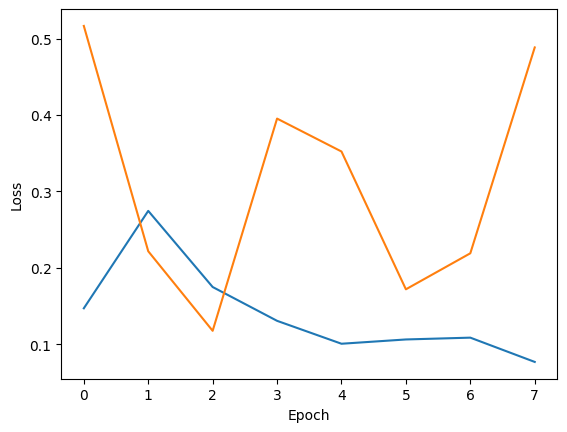

<Figure size 800x800 with 0 Axes>

In [ ]:
# Plot training and validation loss curves
plt.plot(train_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.figure(figsize=(8, 8))
plt.show()




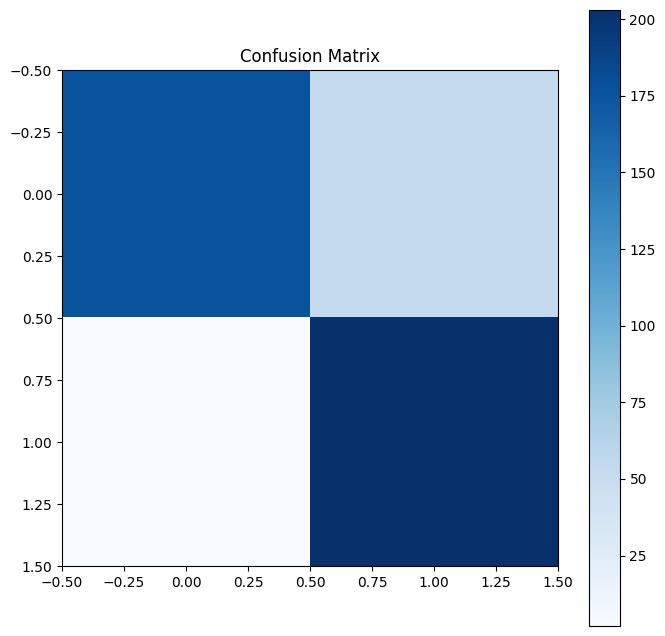

In [ ]:
# Plot confusion matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.show()


In [ ]:
# Additional metrics
f1 = f1_score(test_labels, test_preds, average='weighted')
precision = precision_score(test_labels, test_preds, average='weighted')
recall = recall_score(test_labels, test_preds, average='weighted')

print(f"F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Classification report
class_report = classification_report(test_labels, test_preds, target_names=dataset.class_names)
print("Classification Report:\n", class_report)

# Save the model
save_model = input("Do you want to save the trained model? (yes/no): ").lower()
if save_model == "yes":
    model_save_path = "mobilenetv3_adam_small.pth"  # Adjust the filename as needed
    torch.save(model.state_dict(), model_save_path)
    print("Model saved.")


F1 Score: 0.8723
Precision: 0.8963
Recall: 0.8733
Classification Report:
               precision    recall  f1-score   support

      normal       0.99      0.77      0.86       229
    abnormal       0.79      0.99      0.88       205

    accuracy                           0.87       434
   macro avg       0.89      0.88      0.87       434
weighted avg       0.90      0.87      0.87       434

Do you want to save the trained model? (yes/no): y


 Evaluation Metrics:
 - F1 Score (0.8723): A balanced measure of precision and recall.
 - Precision (0.8963): The accuracy of positive predictions.
 - Recall (0.8733): The ability to identify all relevant instances.
 - Classification Report: Detailed metrics for each class ("normal" and "abnormal").
   - For "normal": High precision (few false positives), moderate recall.
   - For "abnormal": Good precision, very high recall (few false negatives).
 - Accuracy (0.87): Overall correct predictions.
 - Macro Avg and Weighted Avg: Averages for precision, recall, and F1-score.
In summary, the model seems to perform well with a good balance between precision and recall. The detailed classification report provides insights into the performance for each class.






In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_params = count_parameters(model)
print(f"Number of trainable parameters in the model: {num_params}")


Number of trainable parameters in the model: 1519906


In [ ]:
import time

# Use a sample input for inference
sample_input = torch.randn(1, 3, 125, 125).to(device)

# Measure inference time
model.eval()
with torch.no_grad():
    start_time = time.time()
    _ = model(sample_input)
    inference_time = time.time() - start_time

print(f"Inference time for a sample input: {inference_time} seconds")


Inference time for a sample input: 0.015441417694091797 seconds
